## CS4035 - Cyber Data Analytics (Lab 1 -Fraud Data)

### Group Number : 33
### Student 1 
#### Name : Shipra Sharma
#### ID : 5093406
### Student 2
#### Name : Sudharshan Swaminathan
#### ID : 5148340

### Readme (setup instructions)

We installed two explicit modules named `scikit-learn` and `imblearn`. This could be done using `pip install` command in your python environment. Apart from these, all the functions and objects needed are included in the import statements. The other modules that are being imported are `numpy`, `matplotlib`, and `pandas`. These should have already been installed on your system while doing the assignment. 


#### Import statements
Following inbuilt functions/objects have been used to implement the requiremets.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction import FeatureHasher
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datetime import datetime, date
from matplotlib import pyplot
import statistics
import random


#### Data Preprocessing
We load the raw data in our dataframe and drop booking date and txid due to less relevance. We also drop the rows corresponding to the refused value of simple_journal as it creates ambiguity whether a transaction is fraud or non-fraud (benign). We then adjust the data type of a few of the columns like creationdate is converted to date-time format for panda to read it. Also, in the preprocessing step we create two labels for the class i.e 0 and 1 for benign and fraud respectively and make corresponding dataframes. At last we convert the amount into standardised USD amount and create a new column corresponding to it.

In [34]:
#Step 1: Loading the raw data file into our initial dataframe - df and using dtype object to interpret bin and amount as string and integer respectively
df = pd.read_csv('data_for_student_case.csv' , dtype={'bin':str, 'amount':int} , na_filter=False)

#Step 2: Cleaning and formatting the raw data
# dropping refused data as it creates ambiguity whether the transaction is fraud or not
#dropping null values from bin (issuer id) and email id
df = df.drop(['txid','bookingdate'], axis='columns')
df = df[df['simple_journal']!='Refused']
df = df[~df['bin'].str.contains('na', case=False)]
df = df[~df['mail_id'].str.contains('na', case=False)]

#formating columns in terms of their data type like converting creation date in date time format so that panda can read it
df['creationdate'] = (pd.to_datetime(df['creationdate'])).dt.date
df['bin'] = pd.to_numeric(df['bin'])
df['mail_id'] = pd.to_numeric(df['mail_id'].str.replace('email','')).astype(int)                              
df['ip_id'] = pd.to_numeric(df['ip_id'].str.replace('ip','')).astype(int)
df['card_id'] = pd.to_numeric(df['card_id'].str.replace('card','')).astype(int)
df['cardverificationcodesupplied'] = pd.to_numeric(df['cardverificationcodesupplied'].apply(lambda x: '1' if x else '0'))

#adding new column named subscription based on ContAuth
df['subscription'] = pd.to_numeric(df['shopperinteraction'].apply(lambda x: '1' if x == 'ContAuth' else '0'))

# Label the data to get two classes: fraud and benign
df['label'] = pd.to_numeric(df['simple_journal'].apply(lambda x: '1' if x == 'Chargeback' else '0'))
df.head(3)

#converting amount to a homogeneous value (USD) and creatig a new column for the same: usd_amount
money_value = {
    'AUD': 0.702495,
    'GBP': 1.305505,
    'MXN': 0.05274,
    'NZD': 0.6632,
    'SEK': 0.104965
}

def amount_to_usd(values):
    amount, currency = values
    return money_value[currency] * amount / 100
df['usd_amount'] = df[['amount', 'currencycode']].apply(amount_to_usd, axis=1)

#creating fraud and benign dataFrames from label value
fraud_data = df.loc[df['label'] == 1]
benign_data= df.loc[df['label'] == 0]

### 1. Visualization task - plots and respective analysis

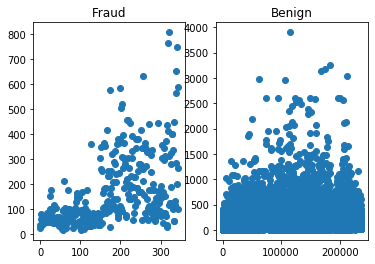

In [35]:
#plotting the relation between the fraud amount and benign amount
plt.subplot(1,2,1)
plt.title('Fraud')
plt.scatter(np.arange(0,len(fraud_data)), fraud_data['usd_amount'])
plt.subplot(1,2,2)
plt.title('Benign')
plt.scatter(np.arange(0,len(benign_data)), benign_data['usd_amount'])

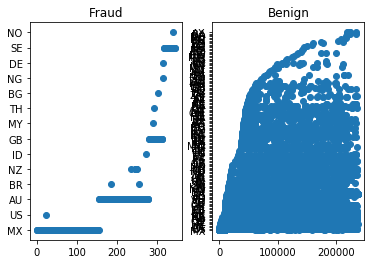

In [36]:
#relation between data and shopper country code
plt.subplot(1,2,1)
plt.title('Fraud')
plt.scatter(np.arange(0,len(fraud_data)), fraud_data['shoppercountrycode'])
plt.subplot(1,2,2)
plt.title('Benign')
plt.scatter(np.arange(0,len(benign_data)), benign_data['shoppercountrycode'])

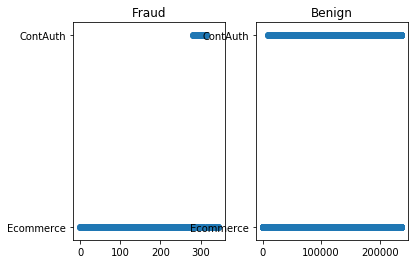

In [9]:
#relation between data and shopper interaction (mode of transaction)
plt.subplot(1,2,1)
plt.title('Fraud')
plt.scatter(np.arange(0,len(fraud_data)), fraud_data['shopperinteraction'])
plt.subplot(1,2,2)
plt.title('Benign')
plt.scatter(np.arange(0,len(benign_data)), benign_data['shopperinteraction'])

1. For the first plot it can be seen that the fraud transcations are made on smaller amount as compared to the benign transactions showing that criminals generally target smaller amount so that the transcation attracts minor attention.
2. The second visual shows that the fraud transactions are mostly happening in three countries: MX, AU and GB. Thus, more attention can be invested here to prevent such cases.
3. The third visual gives a relation between Point of Sale and fraud activities. The online mode (ECommerce) attracts more frauds as compared to ContAuth (recurring events like monthly subscriptions).

### 2. Imbalance task  -  Sudharshan Swaminathan
1. Define smoting function as per the algorithm given in the paper - SMOTE: Synthetic Minority Over-sampling Technique
2. Apply Smoting for three classifiers - Logistic Regression, Random Forest and Gaussian NB
3. Creating ROC curves for smoted and unsmoted data
4. Analyse the performace

In [46]:
#encoding the data
label_encoder = LabelEncoder()
hash_encoder = FeatureHasher(input_type='string')
label_columns  = ['issuercountrycode', 'currencycode', 'shoppercountrycode', 'accountcode', 'mail_id', 'ip_id', 'card_id','txvariantcode', 'shopperinteraction', 'cardverificationcodesupplied']   
for col in label_columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))
    
# a dataframe copy that's used in classification task to extract features and labels
df2 = df.copy()

# removing the following for SMOTE (simple journal as labels are derived from this and creation date wasn't encoded hence keeping only the encoded data in the dataframe)
df_aggregate = df.copy() #used in the bonus task
df = df.drop(['simple_journal','creationdate'], axis='columns')

#redefining fraud and benign data after encoding and dropping a few columns
fraud_data = df.loc[df['label'] == 1]
benign_data= df.loc[df['label'] == 0]

#creating training data
training_fraud_data = fraud_data.sample(n=176) #51-49 ratio for train and test set
training_benign_data = benign_data.sample(n=10000) #10-90 ratio between benign and fraud data for smoting analysis

In [25]:
#defining smote
def smote(training_fraud_data, k):
    t = len(training_fraud_data)
    cols= len(training_fraud_data.columns)
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='kd_tree').fit(training_fraud_data)
    distances, indices = nbrs.kneighbors(training_fraud_data)
    nnarray = []
    data_array = [i for i in range(0,t*k)]
    synthetic = pd.DataFrame(np.nan, index = data_array, columns=training_fraud_data.columns)
    n = 0
    for i in range(len(indices)):
        for j in indices[i]:
            if j != i:
                nnarray.append(j)
        for k in nnarray:
            for m in range(0,cols):
                #diff = training_fraud_data.iloc[k, m] - training_fraud_data.iloc[i, m] -- changed this as '-' is deprecated
                diff = np.subtract(training_fraud_data.iloc[k, m], training_fraud_data.iloc[i, m], dtype = np.float32)               
                gap = random.uniform(0, 1)
                synthetic.iloc[n, m] = training_fraud_data.iloc[i, m] + diff * gap
            n=n+1
        nnarray = []   
    smoted_data = training_fraud_data.append(synthetic, ignore_index=True)    
    return smoted_data
smoted_data = smote(training_fraud_data, 5)

FPR (smoted), TPR (smoted), AUC (smoted):  0.16770186335403728 0.5828658251519402 0.8912257602531675
FPR (unsmoted), TPR (unsmoted), AUC(unsmoted):  0.434088253835286 0.5388370423546303 0.6065148538789324


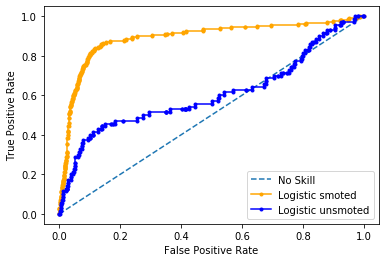

FPR (smoted), TPR (smoted), AUC (smoted):  0.03770415048610537 0.7290221299437889 0.9897705092223646
FPR (unsmoted), TPR (unsmoted), AUC(unsmoted):  0.03106510193401846 0.2785714285714286 0.8291519840430355


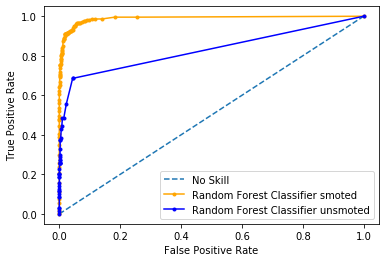

FPR (smoted), TPR (smoted), AUC (smoted):  0.12588378841841447 0.5780075187969925 0.9015118441264451
FPR (unsmoted), TPR (unsmoted), AUC(unsmoted):  0.21155119263003788 0.5837242359630419 0.8611831726555652


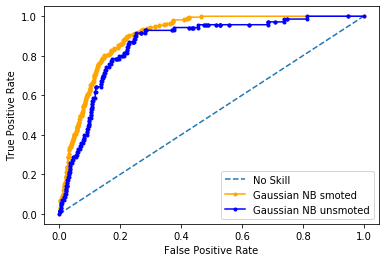

In [26]:
def return_pr(model, testX, testy, ns=False):
    probs = model.predict_proba(testX)[:, 1] if ns is False else [0 for _ in range(len(testy))] # prediction probabilities and keep probabilities for the positive outcome only
    auc = roc_auc_score(testy, probs)
    fpr, tpr, _ = roc_curve(testy, probs)
    return fpr, tpr, auc

# Plotting ROC curves
def plot_roc(testX, testy, testX_unsmoted, testy_unsmoted, model_smoted, model_unsmoted, model_type, legenda = "modified", legendb = "unmodified"):
    # No Skill prediction
    ns_fpr, ns_tpr, ns_auc = return_pr(None, testX, testy, ns=True)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill') #plotting graph
    
    # for the passed model (SMOTED data)
    fpr_smoted, tpr_smoted, auc_smoted = return_pr(model_smoted, testX, testy)
    pyplot.plot(fpr_smoted, tpr_smoted, marker='.',color="orange", label=model_type+" "+legenda) #plotting graph
    
    # for the passed model (UnSMOTED data)
    fpr_unsmoted, tpr_unsmoted, auc_unsmoted = return_pr(model_unsmoted, testX_unsmoted, testy_unsmoted)
    pyplot.plot(fpr_unsmoted, tpr_unsmoted, marker='.',color="blue", label=model_type+" "+legendb) #plotting graph
    print("FPR ("+legenda+"), TPR ("+legenda+"), AUC ("+legenda+"): ", statistics.mean(fpr_smoted) , statistics.mean(tpr_smoted), auc_smoted)
    print("FPR ("+legendb+"), TPR ("+legendb+"), AUC("+legendb+"): ", statistics.mean(fpr_unsmoted) , statistics.mean(tpr_unsmoted), auc_unsmoted)
    
    # Plotting the ROC curve for above models
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    
    # show the plot
    pyplot.show()   

def plot_model(model_smoted, model_unsmoted, trainX, trainy, trainX_unsmoted, trainy_unsmoted, model_type, legenda, legendb):
    model_smoted.fit(trainX, trainy)
    model_unsmoted.fit(trainX_unsmoted, trainy_unsmoted)
    plot_roc(testX, testy, testX_unsmoted, testy_unsmoted, model_smoted, model_unsmoted, model_type, legenda, legendb)

    #SMOTED Data
data_X = training_benign_data.append(smoted_data, ignore_index=True)
y = data_X['label'].values
data_X = data_X.drop(['label'], axis='columns')
trainX, testX, trainy, testy = train_test_split(data_X, y, test_size=0.20)

# unsmoted_data = df.sample(n=12000)
unsmoted_data = df.copy()
z = unsmoted_data['label'].values
unsmoted_data = unsmoted_data.drop(['label'], axis='columns')
trainX_unsmoted, testX_unsmoted, trainy_unsmoted, testy_unsmoted = train_test_split(unsmoted_data, z, test_size=0.20)

# Logistic Regression
plot_model(LogisticRegression(solver='lbfgs'), LogisticRegression(solver='lbfgs'), trainX, trainy, trainX_unsmoted, trainy_unsmoted, "Logistic", "smoted", "unsmoted")

#RandomForestClassifier
plot_model(RandomForestClassifier(), RandomForestClassifier(), trainX, trainy, trainX_unsmoted, trainy_unsmoted, "Random Forest Classifier", "smoted", "unsmoted" )

#GaussianNB
plot_model(GaussianNB(),GaussianNB(), trainX, trainy, trainX_unsmoted, trainy_unsmoted, "Gaussian NB", "smoted", "unsmoted")

#### Classifiers Performance
We compare Logistic Regression, Random Forests and Naive Bayes classifiers on both smoted and unsmoted data. We observe that Random Forests overall perform the best (with Smoted data). When working with Smoted data, it has the least False Positive rate and the maximum True Positive rate, and also having the maximum AUC for ROC. This goes to show that this classifier performs with relatively better accuracy than other classifiers working with Smoted data. Random Forests and Logisitic Regression give better results with Smoted data, while Gaussian NB gives almost the same results for Smoted and unsmoted data. With unsmoted data however, Gaussian Naive Bayes seems to perform better than the other 2 in terms of AUC, but has higher false positive rate than Random Forests. Logistic Regression performs the least with unsmoted data with the highest false positive rate.
#### Is SMOTE a good Idea
Considering that false positives are reduced when using Smote-ing data for all the 3 classifiers used above and also increases the true positive rates for 2 of them, we can say that Smote-ing the data gives a better dataset to work with while performing classification. Therefore, smote-ing (oversampling) along with undersampling is efficient while preparing the training data set and enables us to build a better classifier.

### 3. Privacy task – Shipra Sharma
1. Define rank swapping function for identifying(numerical) data i.e. for the following columns: bin, usd_amount, mail_id, ip_id, card_id. In order to do this we first sort the entire data list as per a column and then swap the row values within a restricted range (p) of the concerned column. We repeat this for the given 5 columns.
2. Apply rank swapping on smoted data for three classifiers - Logistic Regression, Random Forest and Gaussian NB
3. Creating ROC curves for smoted and unsmoted data
4. Analyse the performace

In [28]:
def rank_swapping(df_swapping, column, p=10):
    max_length = len(df_swapping)
    p = int(p * 0.01 * max_length)
    column_list = list(map(lambda c: c, df_swapping.columns))
    column_index = column_list.index(column)
    df_swapping = df_swapping.sort_values(by=column)
    df_swapping = df_swapping.reset_index(drop=True)
    for current_index in range(0, max_length):
        to_swap = current_index + random.randint(0, p)
        if to_swap > max_length-1:
            to_swap = current_index + random.randint(0, (max_length - current_index - 1))
        df_swapping.at[current_index, column], df_swapping.at[to_swap, column] = df_swapping.iloc[to_swap, column_index], df_swapping.iloc[current_index, column_index]
    return df_swapping

smoted done
bin swapped
usd_amount swapped
mail_id swapped
ip_id swapped
card_id swapped
FPR (swapped), TPR (swapped), AUC (swapped):  0.2789508689202274 0.5160901030247764 0.7313615047998306
FPR (unswapped), TPR (unswapped), AUC(unswapped):  0.35144815065861335 0.5535714285714286 0.7038907189700505


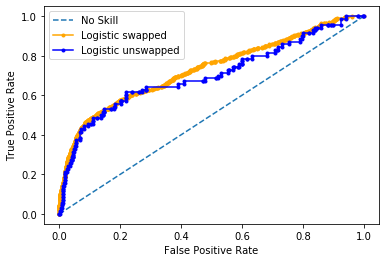

FPR (swapped), TPR (swapped), AUC (swapped):  0.016451359876278795 0.541739483844747 0.9880397233266909
FPR (unswapped), TPR (unswapped), AUC(unswapped):  0.02146921937804104 0.7052380952380952 0.9915162138475022


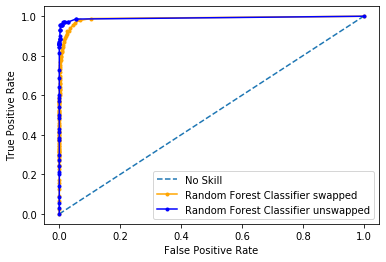

FPR (swapped), TPR (swapped), AUC (swapped):  0.14370208280365768 0.5324720859855995 0.8662131350853474
FPR (unswapped), TPR (unswapped), AUC(unswapped):  0.20904665682209214 0.5805770584095707 0.8655439874278461


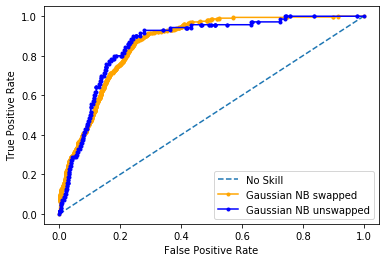

In [30]:
#apply rank swapping
fraud_data = df.loc[df['label'] == 1]
benign_data= df.loc[df['label'] == 0]
smoted_data = smote(fraud_data, 7)
smoted_data = benign_data.append(smoted_data, ignore_index = True)

df_swapping = smoted_data.copy()
print("smoted done")
columns_to_swap = ['bin','usd_amount', 'mail_id','ip_id','card_id']
for column in columns_to_swap:
    df_swapping = rank_swapping(df_swapping, column)
    print(column, "swapped")

#Swapped Data
y = df_swapping['label'].values
data_X = df_swapping.drop(['label'], axis='columns')
trainX, testX, trainy, testy = train_test_split(data_X, y, test_size=0.20)

# Unswapped data
unswapped_data = smoted_data.copy()
z = unswapped_data['label'].values
unswapped_data = unswapped_data.drop(['label'], axis='columns')
trainX_unswapped, testX_unswapped, trainy_unswapped, testy_unswapped = train_test_split(unswapped_data, z, test_size=0.20)

#Plotting ROC Curves

# Logistic Regression
plot_model(LogisticRegression(solver='lbfgs'), LogisticRegression(solver='lbfgs'), trainX, trainy, trainX_unswapped, trainy_unswapped, "Logistic", "swapped", "unswapped")

#RandomForestClassifier
plot_model(RandomForestClassifier(), RandomForestClassifier(), trainX, trainy, trainX_unswapped, trainy_unswapped, "Random Forest Classifier", "swapped", "unswapped")

#GaussianNB
plot_model(GaussianNB(),GaussianNB(), trainX, trainy, trainX_unswapped, trainy_unswapped, "Gaussian NB", "swapped", "unswapped")

#### Classifiers Performance
We compare Logistic Regression, Random Forests and Naive Bayes classifiers on both swapped and unswapped data. We observe that Random Forests overall performs the best as it has the lowest False Positive Rate i.e less benign classes are labeled as fraud, however, the true positive rate is somewhat same for all the three classifiers. We also performed the rank swapping on unsmotted data and found that it is less efficient as compared to the smoted data and hence, we include the same in our work. Logistic Regression classifier seems to perform the worst out of the lot with highest false positive rate for both swapped and unswapped data, comparatively less true positive rate and least area under the curve. GaussianNB performs better than logistic regression. Random Forest works the best in general because of the tree structure that it uses internally. The bagging and features randomness helps to create random trees with uncorrelated forest of trees and in the given dataset there are multiple features like shoppercountrycode, amount, etc. which give predictive power to these trees, and even if some of the trees are wrong, they vote as one and the prediction of the whole group is elected which in turn makes the whole classifier perform well and make good predictions.
#### Is Rank-Swapping a good idea
As per our analysis **Rank swapping is a good idea** because from our results we can see that the performaces of the classifiers are not compromised while using swapped data. Only in case of the Random Forest classifier the true positive rate drops as compared to the unswapped data but in Logistic Regression and GaussianNB the TPR and FPR are marginally close in both the cases. Hence, we get similar performance even when the data is swapped that is data **privacy** is enhanced as the identifying (numerical) data is thoroughly shuffled throughout the dataset.

### 4. Classification task
As required, the classification is performed by two classifiers and these classifiers are evaluated using a 10 cross validation in creating different scores like Precision, Recall, True Positives, False Positives, True Negatives, False Negatives, Accuracy, etc.

Firstly a subset of the data is made considering only the most relevant columns from the orginal dataset (most of these are categorical data). Then we build a function to implement 10-cross validator and a fucntion to calculate the most weighted features that lead to a prediction of fraud class (this is used only in white box algorithm).

The training is done using smoted Data for both the classifiers and the test is performed on a part of the original data(unsmoted).

In [41]:
#selecting only the most relevant attributes from the provided data and using them as features (except label which is used to provide labels for training and evaluation)
dfsubset = df2[['issuercountrycode', 'txvariantcode', 'usd_amount', 'currencycode', 'shoppercountrycode',
                  'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode' ,'label']]
labels = dfsubset.label
dfsubset = dfsubset.drop('label', axis=1)
features = pd.get_dummies(dfsubset)
def ten_fold_validation(classifier, features, labels):    
    k_fold = KFold(n_splits=10, shuffle=True, random_state=42)   
    TP_all = []
    FP_all = []
    TN_all = []
    FN_all = []
    AUC_all = []
    accuracy=[]
    f1_measure=[]
    Recall=[]
    precision=[]
    for train_index, test_index in k_fold.split(features):
        
        train_feature, test_feature = features.iloc[train_index], features.iloc[test_index]
        train_label, test_label = labels.iloc[train_index], labels.iloc[test_index]
        
        df_train = pd.DataFrame(train_feature)
        df_train.loc[:,'label'] = train_label
        df_train_fraud = df_train.loc[df_train['label'] == 1]
        df_train_benign = df_train.loc[df_train['label'] == 0]
        
        smoted = smote(df_train_fraud, 50)
        smoted_labels = smoted["label"].values
        smoted = smoted.drop('label', axis=1)
        
        df_train_benign2 = df_train_benign.drop('label',axis = 1)
        
        train_feature = df_train_benign2.append(smoted, ignore_index = True)
        train_label = np.append(df_train_benign["label"].values,smoted_labels)
        
        classifier.fit(train_feature, train_label)            
        
        predict_label = classifier.predict(test_feature)
        
        conf_matrix = confusion_matrix(test_label, predict_label, labels=[1, 0])
        acc= accuracy_score(predict_label,test_label)*100
        f1= f1_score(predict_label,test_label)*100
        rec= recall_score(predict_label,test_label)*100
        prec=precision_score(predict_label,test_label)*100
        TP = conf_matrix[0][0]
        FP = conf_matrix[1][0]
        TN = conf_matrix[1][1]
        FN = conf_matrix[0][1]
        
        predict_label_probability = classifier.predict_proba(test_feature)[:, 1]
        AUC = roc_auc_score(test_label, predict_label_probability)     
        
        TP_all.append(TP)
        FP_all.append(FP)
        TN_all.append(TN)
        FN_all.append(FN)
        AUC_all.append(AUC)
        accuracy.append(acc)
        f1_measure.append(f1)
        Recall.append(rec)
        precision.append(prec)    
    
    TP_all = np.array(TP_all)
    FP_all = np.array(FP_all)
    TN_all = np.array(TN_all)
    FN_all = np.array(FN_all)
    AUC_all = np.array(AUC_all)
    accuracy=np.array(accuracy)
    f1_measure=np.array(f1_measure)
    Recall=np.array(Recall)
    precision=np.array(precision)
    
    print("Accuracy: {}".format(np.mean(accuracy)))
    print("Recall: {}".format(np.mean(Recall)))
    print("Precision: {}".format(np.mean(precision)))
    print("F-measure: {}".format(np.sum(f1_measure)))
    print("AUC: {}".format(np.sum(AUC)))
    print("True positives: {}".format(np.sum(TP_all)))
    print("False positives: {}".format(np.sum(FP_all)))
    print("True negatives: {}".format(np.sum(TN_all)))
    print("False negatives: {}".format(np.sum(FN_all)))

* Black Box Classification using **Random Forest**

We choose Random Forest as a black box classifier because in this task a good performing classifier is needed and as explained in the above section that the random forest generally peforms better due to the tree structure it creates internally because of which the predictions turn out to be good. This internal structure becomes our second reason for using random forest as a black box classifier, because the complex internal structure might be difficult to explain and the requirement gives us a leverage to focus only on performace in this task.
During the implementation the maximum depth of the tree is taken to be 6 as that helped us to reduce the number of false positives in the model's predcition as more depth of the tree allows more split and capturing of the data.

In [42]:
classifier =RandomForestClassifier(max_depth=6, criterion="gini", random_state=0)
ten_fold_validation(classifier, features, labels)

Accuracy: 98.79339906205004
Recall: 4.133775439263266
Precision: 30.767940392940396
F-measure: 71.20531724672752
AUC: 0.9505965981213507
True positives: 104
False positives: 2615
True negatives: 233738
False negatives: 241


Despite of tuning multiple 'k' values (ranging between 10-100) of the smote function, the least false positives that we could get are 2615. However, the algorithm identifies more that 100 true positives. We observed that the increase in 'k' lead to more true positives but also more false positives and vice versa. This might be because larger 'k' leads to more synthetic data generation and thus, both FP and TP increases.

* White Box Classification using **Logistic Regression**

The task focuses on paying more attention to explaining why a particular transaction is labeled as fraud and not on the accuracy. We use logistic regression because our label to define fraud data or benign data is a binary parameter and Logistic Regression can be used when dealing with binary classification. The algorithm uses maximum-likelihood estimation to optimize weight from the training data. In the given data, it is quite easy to identify whether the transaction is fraud or not depending on weights of several parameters. For example, in the visualisations above we saw that certain columns like shoppercountrycode, shopperinteraction easily give away the fraudulent transaction. Thus, weight metrix of such parameters can be easily obtained using LR which makes the analysing task comparatively easier.

In [45]:
classifier=LogisticRegression(C=500, penalty = 'l2')
ten_fold_validation(classifier, features, labels)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

Accuracy: 98.97253015433974
Recall: 2.1238442370010304
Precision: 13.31091824841825
F-measure: 36.10887560407322
AUC: 0.9297579757975797
True positives: 45
False positives: 2132
True negatives: 234221
False negatives: 300


In the result we see that the logistic classifier gave less true positives as compared to the random forest classifier, however calculates less number of false positives and more number of true negatives. From both the results we can conclude that random forest works better in fraud detection task.

In [49]:
classifier.coef_

array([[ 0.02040877, -0.08829829,  0.00683702, -0.31892825,  0.00602958,
        -0.72354173,  0.        , -3.35394242, -0.25586805]])

We see that for the feature coefficients, the logistic regression classifier produces positive weights for issuercountrycode, usd_amount and shoppercountrycode, which could be closer parameters to identify a fraud and the others like cvcresponsecode, accountcode, etc. are negative, hence being closer to the identification of benign data.

### 5. Bonus task
To make the fraud detection better we tried establishing a relation between the fraud and amount deducted per card per month. It is a derived feature that can help us to etablish a relatonship that how many times a card is used in fraudulent transaction in a given month (monthly behaviour of a card involved in fraudulent transactions).

**Please Note:** This takes a lot of time in execution because the aggregation function goes through each row of the entire dataset multiple times. Hence, we coould not come to a proper calculation/output of our aggregator function.

In [ ]:
df_aggregate = df_aggregate.sort_values(by='creationdate')
avg_over_month = np.zeros(len(df_aggregate))
for i in range(0, len(df_aggregate)):
    previous_data = df_aggregate.iloc[0:i]
    current_row = df_aggregate.iloc[i]
    avg = np.array(0)
    if i > 0:
        for row in previous_data.itertuples():
            if row.card_id == current_row.card_id:
                if abs(row.creationdate - current_row.creationdate).days < 31:
                    avg = np.append(avg, row.usd_amount)
    avg_amount = np.mean(avg)
    avg_over_month[i] = avg_amount
    df_aggregate['average'] = avg_over_month
    
display(df_aggregate.head(100))